# XMM-LSS master catalogue

This notebook presents the merge of the pristine catalogues from CFHT Megacam. This has to be conducted separately on XMM-LSS due to the large amount of memory required on this field.



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
33f5ec7 (Wed Dec 6 16:56:17 2017 +0000) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np
from pymoc import MOC

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))

try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

## I - Reading the prepared pristine catalogues

In [4]:
#candels = Table.read("{}/CANDELS.fits".format(TMP_DIR))           # 1.1
#cfht_wirds = Table.read("{}/CFHT-WIRDS.fits".format(TMP_DIR))     # 1.3
cfhtls_wide = Table.read("{}/CFHTLS-WIDE.fits".format(TMP_DIR))   # 1.4a
cfhtls_deep = Table.read("{}/CFHTLS-DEEP.fits".format(TMP_DIR))   # 1.4b
#We no longer use CFHTLenS as it is the same raw data set as CFHTLS-WIDE
# cfhtlens = Table.read("{}/CFHTLENS.fits".format(TMP_DIR))         # 1.5
#decals = Table.read("{}/DECaLS.fits".format(TMP_DIR))             # 1.6
#servs = Table.read("{}/SERVS.fits".format(TMP_DIR))               # 1.8
#swire = Table.read("{}/SWIRE.fits".format(TMP_DIR))               # 1.7
#hsc_wide = Table.read("{}/HSC-WIDE.fits".format(TMP_DIR))         # 1.9a
#hsc_deep = Table.read("{}/HSC-DEEP.fits".format(TMP_DIR))         # 1.9b
#hsc_udeep = Table.read("{}/HSC-UDEEP.fits".format(TMP_DIR))       # 1.9c
#ps1 = Table.read("{}/PS1.fits".format(TMP_DIR))                   # 1.10
#sxds = Table.read("{}/SXDS.fits".format(TMP_DIR))                 # 1.11
sparcs = Table.read("{}/SpARCS.fits".format(TMP_DIR))             # 1.12
#dxs = Table.read("{}/UKIDSS-DXS.fits".format(TMP_DIR))            # 1.13
#uds = Table.read("{}/UKIDSS-UDS.fits".format(TMP_DIR))            # 1.14
#vipers = Table.read("{}/VIPERS.fits".format(TMP_DIR))             # 1.15
#vhs = Table.read("{}/VISTA-VHS.fits".format(TMP_DIR))             # 1.16
#video = Table.read("{}/VISTA-VIDEO.fits".format(TMP_DIR))         # 1.17
#viking = Table.read("{}/VISTA-VIKING.fits".format(TMP_DIR))       # 1.18

## II - Merging tables

We first merge the optical catalogues and then add the infrared ones. We start with PanSTARRS because it coevrs the whole field.

At every step, we look at the distribution of the distances to the nearest source in the merged catalogue to determine the best crossmatching radius.

###  Start with CFHTLS-WIDE

In [5]:
master_catalogue = cfhtls_wide
master_catalogue['cfhtls-wide_ra'].name = 'ra'
master_catalogue['cfhtls-wide_dec'].name = 'dec'
del cfhtls_wide

### Add CFHTLS-DEEP

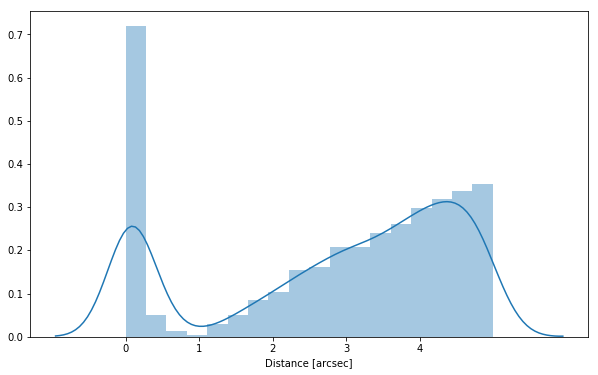

In [6]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(cfhtls_deep['cfhtls-deep_ra'], cfhtls_deep['cfhtls-deep_dec'])
)

In [7]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, 
                                    cfhtls_deep, 
                                    "cfhtls-deep_ra", 
                                    "cfhtls-deep_dec", 
                                    radius=0.8*u.arcsec)

### Add SpARCS

In [8]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(sparcs['sparcs_ra'], sparcs['sparcs_dec'])
)

HELP Warning: There weren't any cross matches. The two surveys probably don't overlap.


In [9]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, sparcs, "sparcs_ra", "sparcs_dec", radius=0.8*u.arcsec)

### Cleaning

When we merge the catalogues, astropy masks the non-existent values (e.g. when a row comes only from a catalogue and has no counterparts in the other, the columns from the latest are masked for that row). We indicate to use NaN for masked values for floats columns, False for flag columns and -1 for ID columns.

In [10]:
for col in master_catalogue.colnames:
    if "m_" in col or "merr_" in col or "f_" in col or "ferr_" in col or "stellarity" in col:
        master_catalogue[col] = master_catalogue[col].astype(float)
        master_catalogue[col].fill_value = np.nan
    elif "flag" in col:
        master_catalogue[col].fill_value = 0
    elif "id" in col:
        master_catalogue[col].fill_value = -1
        
master_catalogue = master_catalogue.filled()

In [11]:
master_catalogue[:10].show_in_notebook()

idx,cfhtls-wide_id,ra,dec,cfhtls-wide_stellarity,m_cfhtls-wide_u,merr_cfhtls-wide_u,m_cfhtls-wide_g,merr_cfhtls-wide_g,m_cfhtls-wide_r,merr_cfhtls-wide_r,m_cfhtls-wide_i,merr_cfhtls-wide_i,m_cfhtls-wide_z,merr_cfhtls-wide_z,m_ap_cfhtls-wide_u,merr_ap_cfhtls-wide_u,m_ap_cfhtls-wide_g,merr_ap_cfhtls-wide_g,m_ap_cfhtls-wide_r,merr_ap_cfhtls-wide_r,m_ap_cfhtls-wide_i,merr_ap_cfhtls-wide_i,m_ap_cfhtls-wide_z,merr_ap_cfhtls-wide_z,f_cfhtls-wide_u,ferr_cfhtls-wide_u,flag_cfhtls-wide_u,f_cfhtls-wide_g,ferr_cfhtls-wide_g,flag_cfhtls-wide_g,f_cfhtls-wide_r,ferr_cfhtls-wide_r,flag_cfhtls-wide_r,f_cfhtls-wide_i,ferr_cfhtls-wide_i,flag_cfhtls-wide_i,f_cfhtls-wide_z,ferr_cfhtls-wide_z,flag_cfhtls-wide_z,f_ap_cfhtls-wide_u,ferr_ap_cfhtls-wide_u,f_ap_cfhtls-wide_g,ferr_ap_cfhtls-wide_g,f_ap_cfhtls-wide_r,ferr_ap_cfhtls-wide_r,f_ap_cfhtls-wide_i,ferr_ap_cfhtls-wide_i,f_ap_cfhtls-wide_z,ferr_ap_cfhtls-wide_z,cfhtls-wide_flag_cleaned,cfhtls-wide_flag_gaia,flag_merged,cfhtls-deep_id,cfhtls-deep_stellarity,m_cfhtls-deep_u,merr_cfhtls-deep_u,m_cfhtls-deep_g,merr_cfhtls-deep_g,m_cfhtls-deep_r,merr_cfhtls-deep_r,m_cfhtls-deep_i,merr_cfhtls-deep_i,m_cfhtls-deep_z,merr_cfhtls-deep_z,m_cfhtls-deep_y,merr_cfhtls-deep_y,m_ap_cfhtls-deep_u,merr_ap_cfhtls-deep_u,m_ap_cfhtls-deep_g,merr_ap_cfhtls-deep_g,m_ap_cfhtls-deep_r,merr_ap_cfhtls-deep_r,m_ap_cfhtls-deep_i,merr_ap_cfhtls-deep_i,m_ap_cfhtls-deep_z,merr_ap_cfhtls-deep_z,m_ap_cfhtls-deep_y,merr_ap_cfhtls-deep_y,f_cfhtls-deep_u,ferr_cfhtls-deep_u,flag_cfhtls-deep_u,f_cfhtls-deep_g,ferr_cfhtls-deep_g,flag_cfhtls-deep_g,f_cfhtls-deep_r,ferr_cfhtls-deep_r,flag_cfhtls-deep_r,f_cfhtls-deep_i,ferr_cfhtls-deep_i,flag_cfhtls-deep_i,f_cfhtls-deep_z,ferr_cfhtls-deep_z,flag_cfhtls-deep_z,f_cfhtls-deep_y,ferr_cfhtls-deep_y,flag_cfhtls-deep_y,f_ap_cfhtls-deep_u,ferr_ap_cfhtls-deep_u,f_ap_cfhtls-deep_g,ferr_ap_cfhtls-deep_g,f_ap_cfhtls-deep_r,ferr_ap_cfhtls-deep_r,f_ap_cfhtls-deep_i,ferr_ap_cfhtls-deep_i,f_ap_cfhtls-deep_z,ferr_ap_cfhtls-deep_z,f_ap_cfhtls-deep_y,ferr_ap_cfhtls-deep_y,cfhtls-deep_flag_cleaned,cfhtls-deep_flag_gaia,sparcs_intid,sparcs_stellarity,m_ap_sparcs_u,merr_ap_sparcs_u,f_ap_sparcs_u,ferr_ap_sparcs_u,m_sparcs_u,merr_sparcs_u,f_sparcs_u,ferr_sparcs_u,flag_sparcs_u,m_ap_sparcs_g,merr_ap_sparcs_g,f_ap_sparcs_g,ferr_ap_sparcs_g,m_sparcs_g,merr_sparcs_g,f_sparcs_g,ferr_sparcs_g,flag_sparcs_g,m_ap_sparcs_r,merr_ap_sparcs_r,f_ap_sparcs_r,ferr_ap_sparcs_r,m_sparcs_r,merr_sparcs_r,f_sparcs_r,ferr_sparcs_r,flag_sparcs_r,m_ap_sparcs_z,merr_ap_sparcs_z,f_ap_sparcs_z,ferr_ap_sparcs_z,m_sparcs_z,merr_sparcs_z,f_sparcs_z,ferr_sparcs_z,flag_sparcs_z,m_ap_sparcs_y,merr_ap_sparcs_y,f_ap_sparcs_y,ferr_ap_sparcs_y,m_sparcs_y,merr_sparcs_y,f_sparcs_y,ferr_sparcs_y,flag_sparcs_y,sparcs_flag_cleaned,sparcs_flag_gaia
,,deg,deg,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,mag,mag,,,,,,,,mag,mag,,,,,,,,mag,mag,,,,,,,,mag,mag,,,,,
0,1103_049200,36.4284824909,-4.49570870959,0.0299999993294,21.6900005341,0.0130000002682,21.0620002747,0.00700000021607,20.0839996338,0.00400000018999,19.5809993744,0.00400000018999,19.3959999084,0.00600000005215,22.2670001984,0.0109999999404,21.5599994659,0.00499999988824,20.6100006104,0.00300000002608,20.1280002594,0.00300000002608,19.8810005188,0.00400000018999,7.65596246719,0.0916682258248,False,13.6521034241,0.0880183652043,False,33.6047058105,0.123804315925,False,53.4072341919,0.196759536862,False,63.3286094666,0.349966824055,False,4.49986696243,0.0455898344517,8.62978363037,0.0397416204214,20.7013912201,0.0572000555694,32.2700424194,0.0891654267907,40.5134963989,0.14925724268,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan

In [12]:
master_catalogue.add_column(Column(data=(np.char.array(master_catalogue['cfhtls-wide_id'].astype(str)) 
                                    +  np.char.array(master_catalogue['cfhtls-deep_id'].astype(str) )
                                    +  np.char.array(master_catalogue['sparcs_intid'].astype(str))), 
                              name="megacam_intid"))

In [13]:
id_names = []
for col in master_catalogue.colnames:
    if '_id' in col:
        id_names += [col]
    if '_intid' in col:
        id_names += [col]
        
print(id_names)

['cfhtls-wide_id', 'cfhtls-deep_id', 'sparcs_intid', 'megacam_intid']


## VII - Choosing between multiple values for the same filter



### VII.b CFHTLS-DEEP, CFHTLS-WIDE and SpARCS: CFHT Megacam fluxes

According to Mattia CFHTLenS is built on the same data as CFHTLS-WIDE and should not be included. I have therefore excluded it from the merge above.

CFHTLS-DEEP is prefferred to CFHTLS-WIDE which is prefferred to SpARCS

|             |                  |
|-------------|------------------|
| CFHTLS-WIDE | u, g, r, i, z    |
| CFHTLS-DEEP | u, g, r, i, z, y |
| SpARCS      | u, g, r, z, y    |


In [14]:
megacam_origin = Table()
#megacam_origin.add_column(master_catalogue['help_id'])

In [15]:
megacam_stats = Table()
megacam_stats.add_column(Column(data=['u','g','r','i','z','y'], name="Band"))
for col in ["CFHTLS-DEEP", "CFHTLS-WIDE", "SpARCS"]:
    megacam_stats.add_column(Column(data=np.full(6, 0), name="{}".format(col)))
    megacam_stats.add_column(Column(data=np.full(6, 0), name="use {}".format(col)))
    megacam_stats.add_column(Column(data=np.full(6, 0), name="{} ap".format(col)))
    megacam_stats.add_column(Column(data=np.full(6, 0), name="use {} ap".format(col)))
    

In [16]:

megacam_bands = ['u','g','r','i','z','y'] # Lowercase naming convention (k is Ks)
for band in megacam_bands:

    # Megacam total flux 
    has_cfhtls_deep = ~np.isnan(master_catalogue['f_cfhtls-deep_' + band])
    if band == 'y':
        has_cfhtls_wide = np.full(len(master_catalogue), False)
    else:
        has_cfhtls_wide = ~np.isnan(master_catalogue['f_cfhtls-wide_' + band])
    if band == 'i':
        has_sparcs = np.full(len(master_catalogue), False)
    else:
        has_sparcs = ~np.isnan(master_catalogue['f_sparcs_' + band])
    

    use_cfhtls_deep = has_cfhtls_deep 
    use_cfhtls_wide = has_cfhtls_wide & ~has_cfhtls_deep
    use_sparcs = has_sparcs & ~has_cfhtls_wide & ~has_cfhtls_deep

    f_megacam = np.full(len(master_catalogue), np.nan)
    f_megacam[use_cfhtls_deep] = master_catalogue['f_cfhtls-deep_' + band][use_cfhtls_deep]
    if not (band == 'y'):
        f_megacam[use_cfhtls_wide] = master_catalogue['f_cfhtls-wide_' + band][use_cfhtls_wide]
    if not (band == 'i'):
        f_megacam[use_sparcs] = master_catalogue['f_sparcs_' + band][use_sparcs]

    ferr_megacam = np.full(len(master_catalogue), np.nan)
    ferr_megacam[use_cfhtls_deep] = master_catalogue['ferr_cfhtls-deep_' + band][use_cfhtls_deep]
    if not (band == 'y'):
        ferr_megacam[use_cfhtls_wide] = master_catalogue['ferr_cfhtls-wide_' + band][use_cfhtls_wide]
    if not (band == 'i'):
        ferr_megacam[use_sparcs] = master_catalogue['ferr_sparcs_' + band][use_sparcs]
    
    m_megacam = np.full(len(master_catalogue), np.nan)
    m_megacam[use_cfhtls_deep] = master_catalogue['m_cfhtls-deep_' + band][use_cfhtls_deep]
    if not (band == 'y'):
        m_megacam[use_cfhtls_wide] = master_catalogue['m_cfhtls-wide_' + band][use_cfhtls_wide]
    if not (band == 'i'):
        m_megacam[use_sparcs] = master_catalogue['m_sparcs_' + band][use_sparcs]

    merr_megacam = np.full(len(master_catalogue), np.nan)
    merr_megacam[use_cfhtls_deep] = master_catalogue['merr_cfhtls-deep_' + band][use_cfhtls_deep]
    if not (band == 'y'):
        merr_megacam[use_cfhtls_wide] = master_catalogue['merr_cfhtls-wide_' + band][use_cfhtls_wide]
    if not (band == 'i'):
        merr_megacam[use_sparcs] = master_catalogue['merr_sparcs_' + band][use_sparcs]

    flag_megacam = np.full(len(master_catalogue), False, dtype=bool)
    flag_megacam[use_cfhtls_deep] = master_catalogue['flag_cfhtls-deep_' + band][use_cfhtls_deep]
    if not (band == 'y'):
        flag_megacam[use_cfhtls_wide] = master_catalogue['flag_cfhtls-wide_' + band][use_cfhtls_wide]
    if not (band == 'i'):
        flag_megacam[use_sparcs] = master_catalogue['flag_sparcs_' + band][use_sparcs]

    master_catalogue.add_column(Column(data=f_megacam, name="f_megacam_" + band))
    master_catalogue.add_column(Column(data=ferr_megacam, name="ferr_megacam_" + band))
    master_catalogue.add_column(Column(data=m_megacam, name="m_megacam_" + band))
    master_catalogue.add_column(Column(data=merr_megacam, name="merr_megacam_" + band))
    master_catalogue.add_column(Column(data=flag_megacam, name="flag_megacam_" + band))

    old_cfhtls_deep_columns = ['f_cfhtls-deep_' + band,
                               'ferr_cfhtls-deep_' + band,
                               'm_cfhtls-deep_' + band, 
                               'merr_cfhtls-deep_' + band,
                               'flag_cfhtls-deep_' + band]
    old_cfhtls_wide_columns = ['f_cfhtls-wide_' + band,
                               'ferr_cfhtls-wide_' + band,
                               'm_cfhtls-wide_' + band, 
                               'merr_cfhtls-wide_' + band,
                               'flag_cfhtls-wide_' + band]
    old_sparcs_columns =      ['f_sparcs_' + band,
                               'ferr_sparcs_' + band,
                               'm_sparcs_' + band, 
                               'merr_sparcs_' + band,
                               'flag_sparcs_' + band]
    
    if (band == 'i'):
        old_columns = old_cfhtls_deep_columns + old_cfhtls_wide_columns
    elif (band == 'y'):
        old_columns = old_cfhtls_deep_columns + old_sparcs_columns
    else:
        old_columns = old_cfhtls_deep_columns + old_cfhtls_wide_columns + old_sparcs_columns
    master_catalogue.remove_columns(old_columns)

    origin = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin[use_cfhtls_deep] = "CFHTLS-DEEP"
    origin[use_cfhtls_wide] = "CFHTLS-WIDE"
    origin[use_sparcs] = "SpARCS"
    
    megacam_origin.add_column(Column(data=origin, name= 'f_megacam_' + band ))
    
    # Megacam aperture flux 
    has_ap_cfhtls_deep = ~np.isnan(master_catalogue['f_ap_cfhtls-deep_' + band])
    if band == 'y':
        has_ap_cfhtls_wide = np.full(len(master_catalogue), False)
    else:
        has_ap_cfhtls_wide = ~np.isnan(master_catalogue['f_ap_cfhtls-wide_' + band])
    if band == 'i':
        has_ap_sparcs = np.full(len(master_catalogue), False)
    else:
        has_ap_sparcs = ~np.isnan(master_catalogue['f_ap_sparcs_' + band])
    

    use_ap_cfhtls_deep = has_ap_cfhtls_deep 
    use_ap_cfhtls_wide = has_ap_cfhtls_wide & ~has_ap_cfhtls_deep
    use_ap_sparcs = has_ap_sparcs & ~has_ap_cfhtls_wide & ~has_ap_cfhtls_deep

    f_ap_megacam = np.full(len(master_catalogue), np.nan)
    f_ap_megacam[use_ap_cfhtls_deep] = master_catalogue['f_ap_cfhtls-deep_' + band][use_ap_cfhtls_deep]
    if not (band == 'y'):
        f_ap_megacam[use_ap_cfhtls_wide] = master_catalogue['f_ap_cfhtls-wide_' + band][use_ap_cfhtls_wide]
    if not (band == 'i'):
        f_ap_megacam[use_ap_sparcs] = master_catalogue['f_ap_sparcs_' + band][use_ap_sparcs]

    ferr_ap_megacam = np.full(len(master_catalogue), np.nan)
    ferr_ap_megacam[use_ap_cfhtls_deep] = master_catalogue['ferr_ap_cfhtls-deep_' + band][use_ap_cfhtls_deep]
    if not (band == 'y'):
        ferr_ap_megacam[use_ap_cfhtls_wide] = master_catalogue['ferr_ap_cfhtls-wide_' + band][use_ap_cfhtls_wide]
    if not (band == 'i'):
        ferr_ap_megacam[use_ap_sparcs] = master_catalogue['ferr_ap_sparcs_' + band][use_ap_sparcs]
    
    m_ap_megacam = np.full(len(master_catalogue), np.nan)
    m_ap_megacam[use_ap_cfhtls_deep] = master_catalogue['m_ap_cfhtls-deep_' + band][use_ap_cfhtls_deep]
    if not (band == 'y'):
        m_ap_megacam[use_ap_cfhtls_wide] = master_catalogue['m_ap_cfhtls-wide_' + band][use_ap_cfhtls_wide]
    if not (band == 'i'):
        m_ap_megacam[use_ap_sparcs] = master_catalogue['m_ap_sparcs_' + band][use_ap_sparcs]

    merr_ap_megacam = np.full(len(master_catalogue), np.nan)
    merr_ap_megacam[use_ap_cfhtls_deep] = master_catalogue['merr_ap_cfhtls-deep_' + band][use_ap_cfhtls_deep]
    if not (band == 'y'):
        merr_ap_megacam[use_ap_cfhtls_wide] = master_catalogue['merr_ap_cfhtls-wide_' + band][use_ap_cfhtls_wide]
    if not (band == 'i'):
        merr_ap_megacam[use_ap_sparcs] = master_catalogue['merr_ap_sparcs_' + band][use_ap_sparcs]



    master_catalogue.add_column(Column(data=f_ap_megacam, name="f_ap_megacam_" + band))
    master_catalogue.add_column(Column(data=ferr_ap_megacam, name="ferr_ap_megacam_" + band))
    master_catalogue.add_column(Column(data=m_ap_megacam, name="m_ap_megacam_" + band))
    master_catalogue.add_column(Column(data=merr_ap_megacam, name="merr_ap_megacam_" + band))


    old_ap_cfhtls_deep_columns = ['f_ap_cfhtls-deep_' + band,
                               'ferr_ap_cfhtls-deep_' + band,
                               'm_ap_cfhtls-deep_' + band, 
                               'merr_ap_cfhtls-deep_' + band]
    old_ap_cfhtls_wide_columns = ['f_ap_cfhtls-wide_' + band,
                               'ferr_ap_cfhtls-wide_' + band,
                               'm_ap_cfhtls-wide_' + band, 
                               'merr_ap_cfhtls-wide_' + band]
    old_ap_sparcs_columns =      ['f_ap_sparcs_' + band,
                               'ferr_ap_sparcs_' + band,
                               'm_ap_sparcs_' + band, 
                               'merr_ap_sparcs_' + band]
    
    if (band == 'i'):
        old_ap_columns = old_ap_cfhtls_deep_columns + old_ap_cfhtls_wide_columns
    elif (band == 'y'):
        old_ap_columns = old_ap_cfhtls_deep_columns + old_ap_sparcs_columns
    else:
        old_ap_columns = old_ap_cfhtls_deep_columns + old_ap_cfhtls_wide_columns + old_ap_sparcs_columns
    master_catalogue.remove_columns(old_ap_columns)

    origin_ap = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin_ap[use_ap_cfhtls_deep] = "CFHTLS-DEEP"
    origin_ap[use_ap_cfhtls_wide] = "CFHTLS-WIDE"
    origin_ap[use_ap_sparcs] = "SpARCS"
    
    megacam_origin.add_column(Column(data=origin_ap, name= 'f_ap_megacam_' + band ))
    

   
    megacam_stats['CFHTLS-DEEP'][megacam_stats['Band'] == band] = np.sum(has_cfhtls_deep)
    megacam_stats['CFHTLS-WIDE'][megacam_stats['Band'] == band] = np.sum(has_cfhtls_wide)
    megacam_stats['SpARCS'][megacam_stats['Band'] == band] = np.sum(has_sparcs)
    megacam_stats['use CFHTLS-DEEP'][megacam_stats['Band'] == band] = np.sum(use_cfhtls_deep)
    megacam_stats['use CFHTLS-WIDE'][megacam_stats['Band'] == band] = np.sum(use_cfhtls_wide)
    megacam_stats['use SpARCS'][megacam_stats['Band'] == band] = np.sum(use_sparcs)
    megacam_stats['CFHTLS-DEEP ap'][megacam_stats['Band'] == band] = np.sum(has_ap_cfhtls_deep)
    megacam_stats['CFHTLS-WIDE ap'][megacam_stats['Band'] == band] = np.sum(has_ap_cfhtls_wide)
    megacam_stats['SpARCS ap'][megacam_stats['Band'] == band] = np.sum(has_ap_sparcs)
    megacam_stats['use CFHTLS-DEEP ap'][megacam_stats['Band'] == band] = np.sum(use_ap_cfhtls_deep)
    megacam_stats['use CFHTLS-WIDE ap'][megacam_stats['Band'] == band] = np.sum(use_ap_cfhtls_wide)
    megacam_stats['use SpARCS ap'][megacam_stats['Band'] == band] = np.sum(use_ap_sparcs)

In [17]:
megacam_stats.show_in_notebook()

idx,Band,CFHTLS-DEEP,use CFHTLS-DEEP,CFHTLS-DEEP ap,use CFHTLS-DEEP ap,CFHTLS-WIDE,use CFHTLS-WIDE,CFHTLS-WIDE ap,use CFHTLS-WIDE ap,SpARCS,use SpARCS,SpARCS ap,use SpARCS ap
0,u,2630,2630,2641,2641,1228,189,1247,194,4290,4290,4152,4152
1,g,3051,3051,3037,3037,1347,194,1357,195,4550,4550,4472,4472
2,r,3130,3130,3135,3135,1350,197,1355,200,4852,4852,4808,4808
3,i,3123,3123,3126,3126,1319,194,1328,195,0,0,0,0
4,z,2779,2779,2811,2811,1158,179,1206,186,4423,4423,4144,4144
5,y,2913,2913,2928,2928,0,0,0,0,4559,4559,4404,4404


In [19]:
megacam_origin.write("{}/xmm-lss_megacam_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)

## XI - Saving the catalogue

In [20]:
master_catalogue.write("{}/megacam_merged_catalogue_xmm-lss{}.fits".format(TMP_DIR, SUFFIX), overwrite=True)